## Import libraries:

In [1]:
from imports import *

# Individual coordinate reconstruction (t,x,y,z)

In [2]:
image = np.load("/data/vidales/images/image_realistic_4comp_1411_corrected_bunch.npy")

**hit_nuvT variable loading**

In [3]:
table = pq.read_table('saved_archives/ophit_variables_y_corrected_bunch.parquet')
nuvT_c_bunch = ak.from_iter(table.column('nuvT_c_bunch').to_pylist())
del table

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
nuvT_c_bunch_np = nuvT_c_bunch.to_numpy()
nuvT_c_bunch_scaled = scaler.fit_transform(nuvT_c_bunch_np)

**Model architecture definition**

In [23]:
def periodic_mse(y_true, y_pred, T):
    return tf.reduce_mean(tf.square(tf.math.mod(y_true - y_pred + T/2, T) - T/2))

In [26]:
def create_cnn_model(x_train, conv_dim):

    from tensorflow.keras import layers, models
    from tensorflow.keras.callbacks import ModelCheckpoint
    """
    Creates a CNN model based on the provided architecture.
    
    Parameters:
    - input_shape: tuple, the shape of the input data (excluding batch size).
    
    Returns:
    - model: A compiled CNN model.
    """
    # Input layer
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
    input_layer = layers.Input(shape=input_shape)
    
    # First convolutional block
    model = layers.Conv2D(32, conv_dim, padding='same')(input_layer)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)
    
    # Second convolutional block
    model = layers.Conv2D(64, conv_dim, padding='same')(model)
    model = layers.BatchNormalization()(input_layer)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)

    # Third convolutional block
    model = layers.Conv2D(128, conv_dim, padding='same')(model)
    model = layers.BatchNormalization()(input_layer)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2,2), padding='same')(model)

    # Fourth convolutional block
    model = layers.Conv2D(256, conv_dim, padding='same')(model)
    model = layers.BatchNormalization()(input_layer)
    model = layers.LeakyReLU(alpha=0.1)(model)

    # Fifth convolutional block
    model = layers.Conv2D(512, conv_dim, padding='same')(model)
    model = layers.BatchNormalization()(input_layer)
    model = layers.LeakyReLU(alpha=0.1)(model)
    
    # Flatten the output and pass through dense layers
    model = layers.Flatten()(model)
    model = layers.Dense(1024, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(512, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(256, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(128, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    
    # Output layer
    output_layer = layers.Dense(1, activation='linear')(model)
    
    # Create the model
    model_def = models.Model(inputs=input_layer, outputs=output_layer)
    
    model_def.compile(optimizer='adam', loss=lambda y_true, y_pred: periodic_mse(y_true, y_pred, T=19), metrics=['mse'])


    return model_def

**model use embeddings as suggested by ChatGPT**

In [19]:
import numpy as np
from tensorflow.keras import layers, models
import tensorflow as tf

import numpy as np

def create_periodic_embeddings(time_values, embedding_dim):
    """
    Creates periodic embeddings (sinusoidal) for time values.

    Parameters:
    - time_values: np.ndarray, input time values of shape (N, 1) or (N,).
    - embedding_dim: int, the number of embedding dimensions (must be even).

    Returns:
    - time_embeddings: np.ndarray, periodic embeddings of shape (len(time_values), embedding_dim).
    """
    # Ensure the embedding dimension is even
    assert embedding_dim % 2 == 0, "Embedding dimension must be even for sine and cosine pairs."

    # Flatten `time_values` if it is 2D
    if len(time_values.shape) > 1:
        time_values = time_values.flatten()  # Convert shape from (N, 1) to (N,)

    # Compute the divisor term
    div_term = np.exp(np.arange(0, embedding_dim, 2) * -(np.log(10000.0) / embedding_dim))
    
    # Initialize the embedding array
    time_embeddings = np.zeros((len(time_values), embedding_dim))
    
    # Compute sine and cosine embeddings
    time_embeddings[:, 0::2] = np.sin(time_values[:, None] * div_term)  # Sine for even indices
    time_embeddings[:, 1::2] = np.cos(time_values[:, None] * div_term)  # Cosine for odd indices
    
    return time_embeddings

from tensorflow.keras import layers, models

def create_cnn_model_with_periodic_output(x_train, conv_dim, y_train, embedding_dim):
    """
    Creates a CNN model that integrates periodic embeddings for the output (time) variable.
    
    Parameters:
    - x_train: np.ndarray, input training data.
    - conv_dim: tuple, dimensions for the convolutional layers.
    - y_train: np.ndarray, time labels (target variable).
    - embedding_dim: int, dimension of the periodic embeddings.
    
    Returns:
    - model: A compiled CNN model.
    """
    # Input shape
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
    input_layer = layers.Input(shape=input_shape)

    # Periodic embeddings for time
    time_embeddings = create_periodic_embeddings(y_train, embedding_dim)
    time_embeddings_input = layers.Input(shape=(embedding_dim,))

    # First convolutional block
    masking_layer = layers.Masking(mask_value=0)(input_layer)
    model = layers.BatchNormalization()(masking_layer)
    model = layers.Conv2D(32, conv_dim, padding='same')(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2, 2), padding='same')(model)

    # Second convolutional block
    model = layers.Conv2D(64, (3, 3), padding='same')(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2, 2), padding='same')(model)

    # Third convolutional block
    model = layers.Conv2D(128, (3, 3), padding='same')(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)
    model = layers.MaxPooling2D((2, 2))(model)

    # Fourth convolutional block
    model = layers.Conv2D(256, (3, 3), padding='same')(model)
    model = layers.BatchNormalization()(model)
    model = layers.LeakyReLU(alpha=0.1)(model)

    # Flatten the output
    model = layers.Flatten()(model)

    # Combine with time embeddings
    concatenated = layers.Concatenate()([model, time_embeddings_input])

    # Dense layers after concatenation
    model = layers.Dense(1024, activation='relu')(concatenated)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(512, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(256, activation='relu')(model)
    model = layers.Dropout(0.3)(model)
    model = layers.Dense(128, activation='relu')(model)
    model = layers.Dropout(0.3)(model)

    # Output layer
    output_layer = layers.Dense(1, activation='linear')(model)

    # Create the model
    model_def = models.Model(inputs=[input_layer, time_embeddings_input], outputs=output_layer)

    # Compile the model
    model_def.compile(loss='mse', optimizer='adam', metrics=['mse'])

    return model_def


## 4-component realistic representation

**Training and set separation**

In [6]:
test_size = int(np.floor(0.30*np.shape(nuvT_c_bunch_scaled)[0]) )
print(test_size)

8825


In [7]:
# prueba (los mapas originales están invertidos en y)
# Invert along the 59 dimension (axis 1)
inverted_image = image[:, ::-1, :, :]

In [8]:
x_train, x_test = inverted_image[:-test_size], inverted_image[-test_size:]
print('x_train dim.:',x_train.shape)
print('x_test dim.:', x_test.shape)

x_train dim.: (20592, 59, 70, 16)
x_test dim.: (8825, 59, 70, 16)


In [9]:
y_train, y_test = nuvT_c_bunch_scaled[:-test_size], nuvT_c_bunch_scaled[-test_size:]

In [27]:
model = create_cnn_model(x_train, (7,7))

In [28]:
y_pred, history= train_and_predict(model, x_train, y_train, x_test, y_test, epochs=100, batch_size=16)

2024-11-29 12:15:37.581176: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5442877440 exceeds 10% of free system memory.
2024-11-29 12:15:41.875923: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5442877440 exceeds 10% of free system memory.


Epoch 1/100
1287/1287 [==============================] - 26s 20ms/step - loss: 0.2196 - mse: 0.2196 - val_loss: 0.1754 - val_mse: 0.1754 - lr: 0.0010
Epoch 2/100
1287/1287 [==============================] - 19s 15ms/step - loss: 0.1782 - mse: 0.1782 - val_loss: 0.1747 - val_mse: 0.1747 - lr: 0.0010
Epoch 3/100
1287/1287 [==============================] - 17s 13ms/step - loss: 0.1766 - mse: 0.1766 - val_loss: 0.1748 - val_mse: 0.1748 - lr: 0.0010
Epoch 4/100
 301/1287 [======>.......................] - ETA: 11s - loss: 0.1747 - mse: 0.1747

KeyboardInterrupt: 

## Prueba time embeddings

In [20]:
# Assuming x_train and y_train are your data
conv_dim = (7, 7)
embedding_dim = 16

# Generate periodic embeddings
time_embeddings = create_periodic_embeddings(y_train, embedding_dim)

# Create the model
model = create_cnn_model_with_periodic_output(x_train, conv_dim, y_train, embedding_dim)

# Fit the model
history = model.fit(
    [x_train, time_embeddings],
    y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2
)

# Make predictions on the test set

2024-11-29 11:56:14.396943: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4354143360 exceeds 10% of free system memory.
2024-11-29 11:56:18.608700: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4354143360 exceeds 10% of free system memory.


Epoch 1/20
515/515 [==============================] - 14s 21ms/step - loss: 0.9289 - mse: 0.9289 - val_loss: 0.1776 - val_mse: 0.1776
Epoch 2/20
515/515 [==============================] - 8s 16ms/step - loss: 0.1863 - mse: 0.1863 - val_loss: 0.1764 - val_mse: 0.1764
Epoch 3/20
515/515 [==============================] - 8s 16ms/step - loss: 0.1781 - mse: 0.1781 - val_loss: 0.1764 - val_mse: 0.1764
Epoch 4/20
515/515 [==============================] - 8s 16ms/step - loss: 0.1781 - mse: 0.1781 - val_loss: 0.1756 - val_mse: 0.1756
Epoch 5/20
515/515 [==============================] - 8s 16ms/step - loss: 0.1768 - mse: 0.1768 - val_loss: 0.1758 - val_mse: 0.1758
Epoch 6/20
515/515 [==============================] - 8s 16ms/step - loss: 0.1763 - mse: 0.1763 - val_loss: 0.1756 - val_mse: 0.1756
Epoch 7/20
515/515 [==============================] - 8s 16ms/step - loss: 0.1767 - mse: 0.1767 - val_loss: 0.1758 - val_mse: 0.1758
Epoch 8/20
515/515 [==============================] - 9s 17ms/step -

ValueError: in user code:

    File "/opt/anaconda3/envs/ROOT_TF/lib/python3.9/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/envs/ROOT_TF/lib/python3.9/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/ROOT_TF/lib/python3.9/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/anaconda3/envs/ROOT_TF/lib/python3.9/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/opt/anaconda3/envs/ROOT_TF/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/envs/ROOT_TF/lib/python3.9/site-packages/keras/engine/input_spec.py", line 199, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 59, 70, 16) dtype=float32>]


In [21]:
y_pred = model.predict(x_test,time_embeddings)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Visualización de resultados

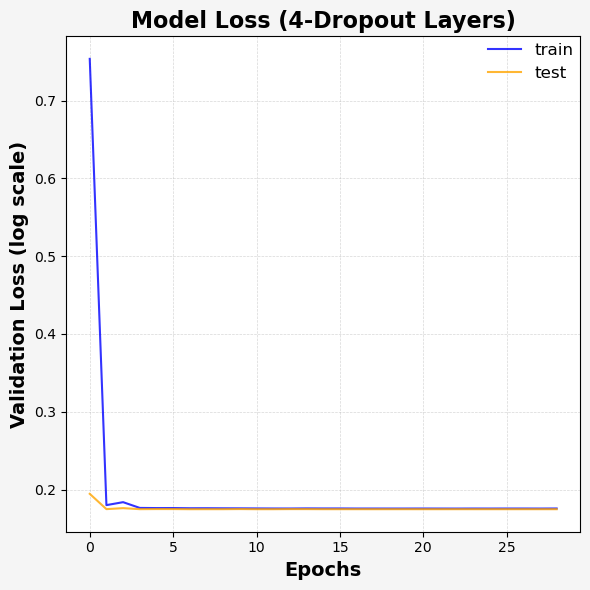

In [13]:
import matplotlib.pyplot as plt

# Access each model's history
model_history = history.history

# Plotting the validation loss for all models
plt.figure(figsize=(6, 6))

# Plot each model's validation loss with smooth lines, subtle markers, and refined styling
plt.plot(model_history['loss'], label='train', color='blue', linestyle='-', markersize=8, alpha=0.8)
plt.plot(model_history['val_loss'], label='test', color='orange', linestyle='-', markersize=8, alpha=0.8)

# Enhance plot appearance
#plt.yscale('log')  # Use logarithmic scale on y-axis
#plt.ylim()
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Validation Loss (log scale)', fontsize=14, fontweight='bold')
plt.title('Model Loss (4-Dropout Layers)', fontsize=16, fontweight='bold')
#plt.ylim(0.1,0.3)
# Refined grid with lighter lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Add legend with better positioning and larger font
plt.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0., frameon=False)

# Add background color for plot to make it stand out
plt.gcf().set_facecolor('whitesmoke')

# Show plot with a tight layout to avoid clipping
plt.tight_layout()
plt.show()


In [25]:
# Initialize a copy of the scaled combined data
y_pred_inverse= np.copy(y_pred)
y_test_inverse= np.copy(y_test)

y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse= scaler.inverse_transform(y_test)

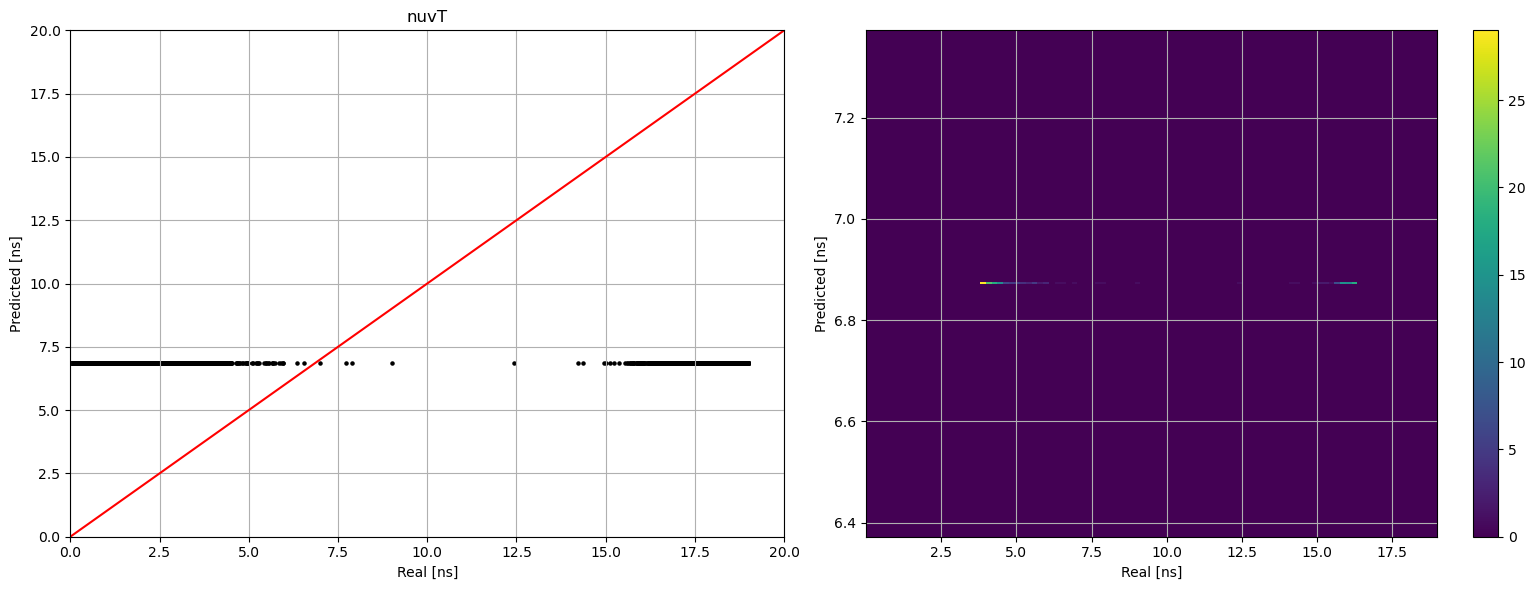

In [30]:
import matplotlib.pyplot as plt

# Assuming y_test_inverse and y_pred_inverse are numpy arrays
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axs[0].scatter(y_test_inverse, y_pred_inverse, color="black",s=5)
axs[0].grid()
axs[0].plot([0, 20], [0, 20], color="r")
axs[0].set_xlim([0, 20])
axs[0].set_ylim([0, 20])
axs[0].set_ylabel('Predicted [ns]')
axs[0].set_xlabel('Real [ns]')

# 2D Histogram
im0 = axs[1].hist2d(y_test_inverse.flatten(), y_pred_inverse.flatten(), bins=(100, 300), cmap='viridis', cmax=30)
fig.colorbar(im0[3], ax=axs[1])
axs[1].grid()
#axs[1].plot([0, 20], [0, 20], 'r')
#axs[1].set_xlim([0, 20])
#axs[1].set_ylim([0, 20])
axs[1].set_ylabel('Predicted [ns]')
axs[1].set_xlabel('Real [ns]')
axs[1].set_facecolor('#440154')

# Adjust layout and show the plot
fig.title('Real vs Predicted nu interaction time')
fig.tight_layout()
plt.show()
#plt.savefig('/tmp/your_image.png', dpi=300)


**Metrics computed**

In [33]:
testScoreMSE_nuvT = mean_squared_error(y_test_inverse, y_pred_inverse)
print('MSE_nuvT: %.4f' % np.sqrt((testScoreMSE_nuvT)))

MSE_nuvT: 7.9410


In [22]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

testScoreMSE_nuvT = mean_squared_error(test_nuvT_compressed_4comp, nuvT_pred_compressed_4comp)
r2 = r2_score(test_nuvT_compressed_4comp, nuvT_pred_compressed_4comp)
mape = mean_absolute_percentage_error(test_nuvT_compressed_4comp, nuvT_pred_compressed_4comp)

print('RMSE: %.3f' % np.sqrt((testScoreMSE_nuvT)))
print('R²: %.3f' % r2)
print('MAPE: %.2f%%' % mape)

RMSE: 7.959
R²: -0.001
MAPE: 1518.90%


**Gaussian fit of the residuals between prediction and actual data to check the quality of the results**

------------------
Media nuvT = 5.580523491402194
Sigma nuvT = 52.49821478635204
------------------


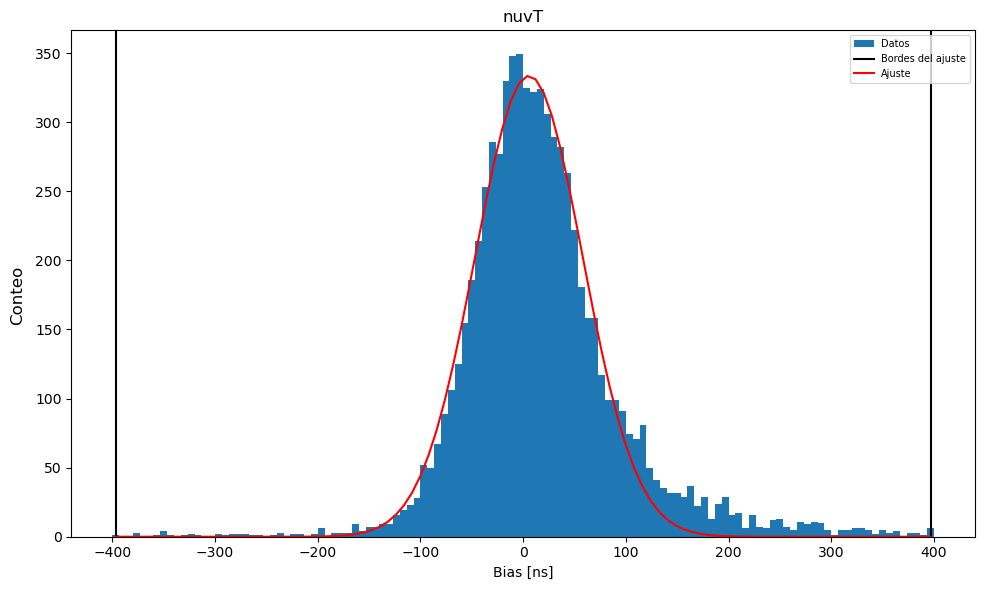

In [16]:
# Gaussian fit of the difference between the prediction and the real value

from scipy.optimize import curve_fit

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Variables de los histogramas
diff_nuvT = nuvT_pred_realistic.flatten()-test_nuvT

fig, axs = plt.subplots(figsize=(10,6))

# Valores de X
axs.title.set_text('nuvT')
counts_nuvT, bins_nuvT, patches_nuvT = axs.hist(diff_nuvT,120, range=[-400,400], label='Data')

step_nuvT = (bins_nuvT[1]-bins_nuvT[0])/2
bin_centers_nuvT = bins_nuvT[:-1]+step_nuvT

ini_nuvT = 0
fin_nuvT = 119
axs.axvline(x = bin_centers_nuvT[ini_nuvT], color = 'k', label='Edge"s fit')
axs.axvline(x = bin_centers_nuvT[fin_nuvT], color = 'k')

popt_nuvT, pcov_nuvT = curve_fit(func, bin_centers_nuvT[ini_nuvT:fin_nuvT+1], counts_nuvT[ini_nuvT:fin_nuvT+1])


ym_nuvT = func(np.linspace(bin_centers_nuvT[ini_nuvT], bin_centers_nuvT[fin_nuvT],100), popt_nuvT[0], popt_nuvT[1], popt_nuvT[2])
axs.plot(np.linspace(bin_centers_nuvT[ini_nuvT], bin_centers_nuvT[fin_nuvT],100), ym_nuvT, c='r', label='Fit')
axs.set_xlabel('Bias [ns]')
axs.legend(prop = { "size": 7 })

fig.supylabel('Count')
fig.tight_layout()

# plt.savefig('/tmp/CNNx2+4T+N_Distrib_I.png', dpi=300)

print('------------------')
print('Mean nuvT =',popt_nuvT[1])
print('St. Dev. nuvT =',popt_nuvT[2])
print('------------------')


In [17]:
print('Gauss nuvT')
print(np.std(diff_nuvT))
print(np.mean(diff_nuvT))

Gauss nuvT
115.17707820363492
24.574550175010334


## Visualización de las representaciones intermedias

Se visualiza las características intermedias aprendidas por la CNN. Se puede observar como la entrada se transforma al pasar através de las capas. Se selecciona una imagen aleatoria del conjunto de entrenamiento y se visualiza durante su transformación. Cada fila corresponde con una capa y cada imagen en la fila con un filtro.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def visualize_intermediate_layers(model, x_train, sample_index=0):
    """
    Visualizes intermediate layer outputs for a specific sample from the training data.
    
    Parameters:
    - model: The trained Keras model.
    - x_train: The training data.
    - sample_index: Index of the sample from x_train to visualize.
    """
    # Get the outputs of all intermediate layers
    successive_outputs = [layer.output for layer in model.layers[1:]]
    visualization_model = Model(inputs=model.input, outputs=successive_outputs)
    
    # Select a sample image from x_train
    sample_image = x_train[sample_index:sample_index + 1]  # Shape should be (1, height, width, channels)
    
    # Pass the image through the model to get intermediate representations
    successive_feature_maps = visualization_model.predict(sample_image)
    
    # Get layer names for labeling
    layer_names = [layer.name for layer in model.layers[1:]]
    
    # Plot each layer's feature map
    for layer_name, feature_map in zip(layer_names, successive_feature_maps):
        if len(feature_map.shape) == 4:  # Only consider convolutional layers (ignore dense layers)
            n_features = feature_map.shape[-1]  # Number of filters
            size = feature_map.shape[1]  # Spatial dimensions
            
            # Create a grid for visualizing each filter's feature map
            display_grid = np.zeros((size, size * n_features))
            
            for i in range(n_features):
                x = feature_map[0, :, :, i]
                
                # Normalize the feature map values for better visualization
                x -= x.mean()
                x /= (x.std() + 1e-5)
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')
                
                # Resize or pad `x` if it doesn't match the expected dimensions
                if x.shape[1] < size:
                    x = np.pad(x, ((0, 0), (0, size - x.shape[1])), mode='constant')
                elif x.shape[1] > size:
                    x = x[:, :size]
                
                # Put each filter's activation in the display grid
                display_grid[:, i * size : (i + 1) * size] = x
            
            # Display the grid
            scale = 20. / n_features
            plt.figure(figsize=(scale * n_features, scale))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
            plt.show()

# Use the function to visualize intermediate representations of your model
# Assuming x_train is your training data and create_cnn_model has been defined
#model, _ = create_cnn_model(x_train, conv_dim=(3, 3), maxpool_dim=(2, 2))
#visualize_intermediate_layers(model, x_train)


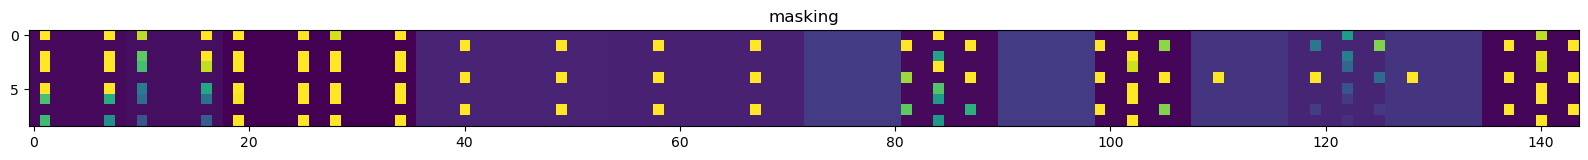

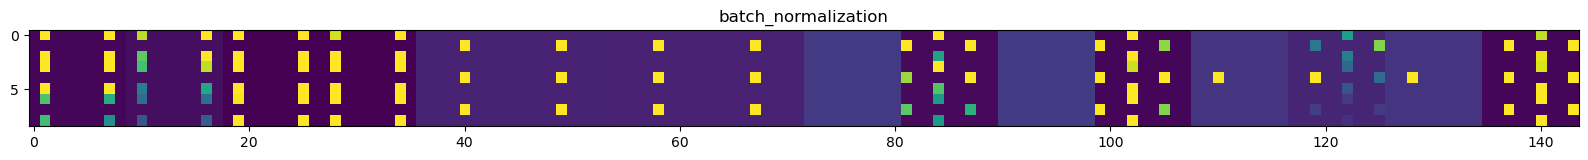

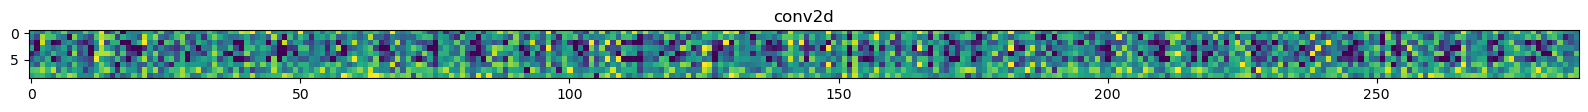

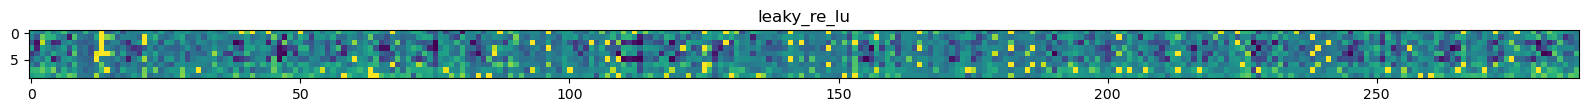

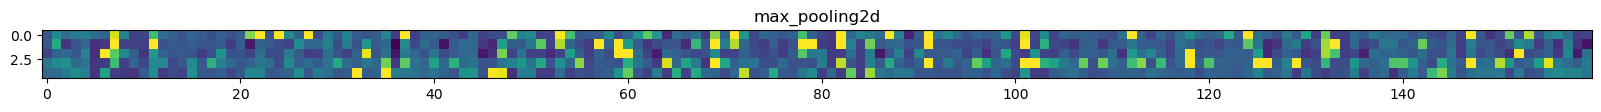

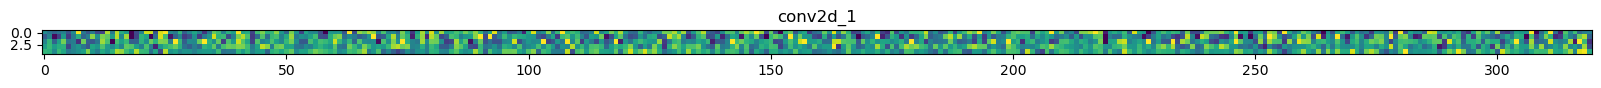

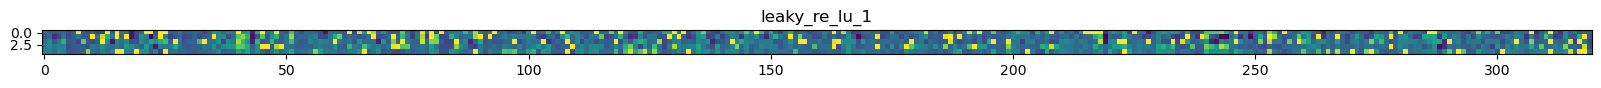

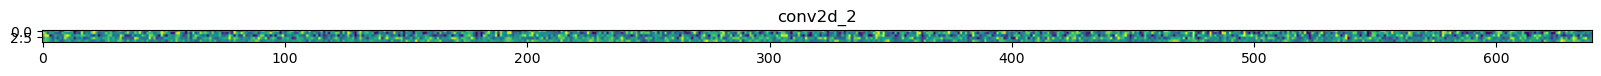

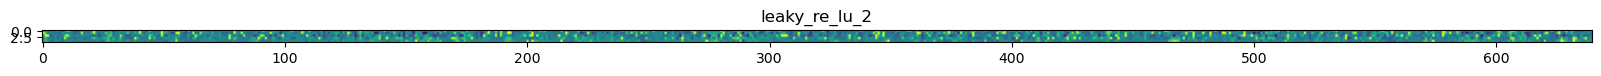

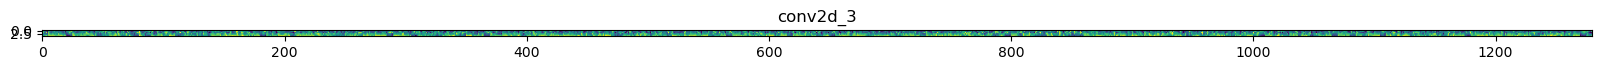

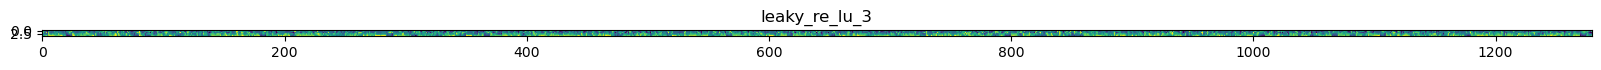

In [ ]:
visualize_intermediate_layers(model_compressed_4comp, x_train_compressed_4comp, sample_index=3)